In [1]:
# Libraries

import numpy
import os
import shutil

In [2]:
# Code

from src.cnn.dataset import GeneDataset
from src.cnn.models  import Washburn2019r

from src.cnn import core    as cnn_core
from src.cnn import dataset as cnn_dataset
from src.cnn import model   as cnn_model
from src.cnn import plot    as cnn_plot
from src.cnn import util    as cnn_util
from src.io  import loader  as data_loader

# 1. Setup

In [3]:
# Setup some directory paths.

OUT_SUBFOLDER = 'nbp07-washburn2019r'
RES_SUBFOLDER = ''

CWD = os.getcwd()
OUT = os.path.join(CWD, 'out')
RES = os.path.join(CWD, 'res')

OUT_PLOT  = os.path.join(OUT, 'plot',  OUT_SUBFOLDER)
OUT_MODEL = os.path.join(OUT, 'model', OUT_SUBFOLDER)
RES_PLANT = os.path.join(RES, 'plant', RES_SUBFOLDER)
RES_MODEL = os.path.join(RES, 'model', RES_SUBFOLDER)
RES_NBP04 = os.path.join(OUT, 'data', 'nbp04-feature')
RES_NBP05 = os.path.join(OUT, 'data', 'nbp05-target')

shutil.rmtree(OUT_PLOT,  ignore_errors = True)
shutil.rmtree(OUT_MODEL, ignore_errors = True)

os.makedirs(OUT_PLOT,  exist_ok = True)
os.makedirs(OUT_MODEL, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT}')
print(f' Resource Directory : {RES}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\out
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\res


In [4]:
# Device

DEVICE = cnn_core.get_device(only_cpu = False)

Graphic devices : 1
Selected device : cuda


In [5]:
# Load the input <gene> features

gene_sequences = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

gene_frequency = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-frequency.npz')
)

gene_stability = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-stability.npz')
)

tpm_value = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-value.json'),
	to_numpy = True
)

tpm_level = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-level.json'),
	to_numpy = True
)

tpm_order = data_loader.load_labels(
	filename = os.path.join(RES_NBP05, 'target-tpm-order.json')
)

# 2. Regression

In [6]:
# Define basic data parameters

config = {
	'random_seed' : 14071994,
	'batch_size'  : [64, 64, 64], # train, valid, eval
	'split_size'  : [60, 20, 20], # train, valid, eval
	'input' : {
		'channels' : 1,
		'height'   : 4,
		'width'    : 2150,
		'features' : 64
	},
	'output' : {
		'group0' : 'tissue',
		'group1' : 'tissue-mean',
		'values' : 8
	}
}

config['split_size'] = [x / 100 for x in config['split_size']]

In [7]:
# Lock random

cnn_core.lock_random(seed = config['random_seed'])

## 2.1 Data

In [8]:
# Get the correct output group

targets = {
	key : value[config['output']['group1']]
	for key, value in tpm_value.items()
}


In [9]:
# Create a <gene> dataset and split it into dataloaders

# expand_dims = None -> [batch_size, H, W]
# expand_dims =   -1 -> [batch_size, H, W]
# expand_dims =    0 -> [batch_size, 1, H, W]
# expand_dims =    1 -> [batch_size, H, 1, W]
# expand_dims =    2 -> [batch_size, H, W, 1]

dataloaders = GeneDataset(
	sequences   = gene_sequences,
	features    = gene_frequency,
	targets     = targets,
	expand_dims = 0
).split_to_dataloader(
	split_size  = config['split_size'],
	batch_size  = config['batch_size'],
	random_seed = config['random_seed'],
	shuffle     = True,
	drop_last   = True
)

train_dataloader = dataloaders[0]
valid_dataloader = dataloaders[1]
test_dataloader  = dataloaders[2]

In [10]:
# Display the training dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = train_dataloader,
	batch_size = config['batch_size'][0]
)

Dataloader  batch  size :     64
Dataloader  batch count :    297
Dataloader sample count : 19,008

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [11]:
# Display the validation dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = valid_dataloader,
	batch_size = config['batch_size'][1]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


In [12]:
# Display the testing dataloader item dimensions

cnn_dataset.show_dataloader(
	dataloader = test_dataloader,
	batch_size = config['batch_size'][2]
)

Dataloader  batch  size :     64
Dataloader  batch count :     99
Dataloader sample count :  6,336

     Key shape : (64,)
Sequence shape : torch.Size([64, 1, 4, 2150])
 Feature shape : torch.Size([64, 64])
  Target shape : torch.Size([64, 8])


## 2.2 Model

In [13]:
# Create and display the model structure

model = Washburn2019r(params = {
	'other' : {
		'in_channels' : config['input']['channels'],
		'in_height'   : config['input']['height'],
		'in_width'    : config['input']['width'],
		'in_features' : config['input']['features'],
		'dropout'     : 0.25
	},
	'conv1' : {
		'kernel'  : (4, 3),
		'padding' : (0, 0)
	},
	'conv2' : {
		'kernel'  : (1, 9),
		'padding' : (0, 4)
	},
	'conv3' : {
		'kernel'  : (1, 9),
		'padding' : (0, 4)
	},
	'conv4' : {
		'kernel'  : (1, 9),
		'padding' : (0, 4)
	},
	'conv5' : {
		'kernel'  : (1, 9),
		'padding' : (0, 4)
	},
	'conv6' : {
		'kernel'  : (1, 9),
		'padding' : (0, 4)
	},
	'maxpool1' : {
		'kernel'  : (1, 3),
		'padding' : (0, 1)
	},
	'maxpool2' : {
		'kernel'  : (1, 3),
		'padding' : (0, 1)
	},
	'maxpool3' : {
		'kernel'  : (1, 3),
		'padding' : (0, 1)
	},
	'fc3' : {
		'features' : config['output']['values']
	}
})

model.summary(
	batch_size  = config['batch_size'][0],
	in_channels = config['input']['channels'],
	in_height   = config['input']['height'],
	in_width    = config['input']['width'],
	in_features = config['input']['features'],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Washburn2019r                            [64, 1, 4, 2150]          [64, 8]                   --
├─Washburn2019: 1-1                      [64, 1, 4, 2150]          [64, 32]                  --
│    └─Conv2d: 2-1                       [64, 1, 4, 2150]          [64, 64, 1, 2148]         832
│    └─ReLU: 2-2                         [64, 64, 1, 2148]         [64, 64, 1, 2148]         --
│    └─Conv2d: 2-3                       [64, 64, 1, 2148]         [64, 64, 1, 2148]         36,928
│    └─ReLU: 2-4                         [64, 64, 1, 2148]         [64, 64, 1, 2148]         --
│    └─MaxPool2d: 2-5                    [64, 64, 1, 2148]         [64, 64, 1, 716]          --
│    └─Dropout: 2-6                      [64, 64, 1, 716]          [64, 64, 1, 716]          --
│    └─Conv2d: 2-7                       [64, 64, 1, 716]          [64, 128, 1, 716]         73,856
│    └─ReLU: 2-8          

In [14]:
# Convert the model to double and initialize weights and biases

model = model.double()
model = model.apply(cnn_model.he_uniform_weight)
model = model.apply(cnn_model.zero_bias)

In [15]:
# Set the training parameters

criterion = cnn_model.get_criterion(
	query     = 'mse',
	reduction = 'mean'
)

optimizer = cnn_model.get_optimizer(
	query        = 'adam',
	model        = model,
	lr           = 1e-4,
	betas        = (0.900, 0.999),
	weight_decay = 0.05
)

scheduler = cnn_model.get_scheduler(
	query     = 'plateau',
	mode      = 'min',
	optimizer = optimizer,
	patience  = 2,
	factor    = 0.5,
	min_lr    = 1e-8
)

params = {
	'model'     : model,
	'savebest'  : os.path.join(OUT_MODEL, f'{model.__name__}-best.pth'), # None if should not save
	'savelast'  : os.path.join(OUT_MODEL, f'{model.__name__}-last.pth'), # None if should not save
	'epochs'    : 100,
	'criterion' : criterion,
	'optimizer' : optimizer,
	'scheduler' : scheduler,
	'device'    : DEVICE,
	'verbose'   : False,
	'train_dataloader' : train_dataloader,
	'valid_dataloader' : valid_dataloader,
	'test_dataloader'  : test_dataloader,
	'metrics' : {
		key : cnn_model.get_criterion(query = key, reduction = 'none')
		for key in ['mse', 'mae', 'huber', 'r2']
	}
}

## 2.3 Training

In [16]:
# Train and validate the model

report = cnn_model.train_regressor(
	model  = model,
	params = params
)

In [17]:
# Display the training and validation loss per epoch

epochs = len(report['train']['loss'])

for epoch in range(epochs) :
	print(f'Epoch {(1 + epoch):03d} :', end = ' ')
	print('{:10.5f}'.format(report['train']['loss'][epoch]), end = ' ')
	print('{:10.5f}'.format(report['valid']['loss'][epoch]))

Epoch 001 :    0.15850    0.04594
Epoch 002 :    0.02933    0.03521
Epoch 003 :    0.02603    0.03398
Epoch 004 :    0.02482    0.03118
Epoch 005 :    0.02434    0.02796
Epoch 006 :    0.02407    0.02688
Epoch 007 :    0.02394    0.02564
Epoch 008 :    0.02382    0.02392
Epoch 009 :    0.02380    0.02374
Epoch 010 :    0.02383    0.02441
Epoch 011 :    0.02384    0.02378
Epoch 012 :    0.02377    0.02362
Epoch 013 :    0.02383    0.02361
Epoch 014 :    0.02395    0.02361
Epoch 015 :    0.02405    0.02352
Epoch 016 :    0.02412    0.02434
Epoch 017 :    0.02422    0.02437
Epoch 018 :    0.02438    0.02467
Epoch 019 :    0.02443    0.02476
Epoch 020 :    0.02444    0.02477
Epoch 021 :    0.02459    0.02477
Epoch 022 :    0.02472    0.02473
Epoch 023 :    0.02478    0.02479
Epoch 024 :    0.02477    0.02514
Epoch 025 :    0.02498    0.02518
Epoch 026 :    0.02508    0.02524
Epoch 027 :    0.02514    0.02532
Epoch 028 :    0.02519    0.02538
Epoch 029 :    0.02523    0.02547
Epoch 030 :   

### 2.3.1 Plots

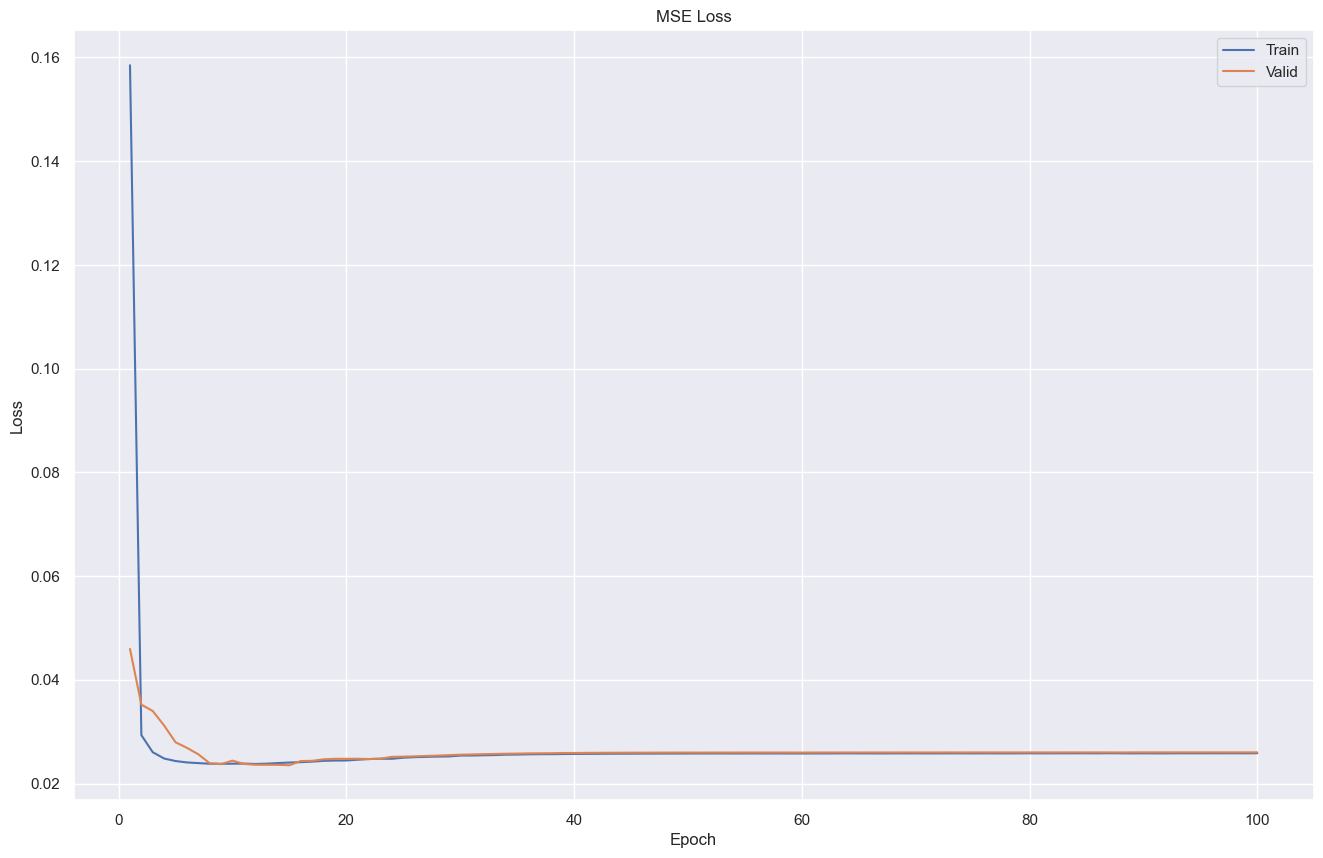

In [18]:
# Display the training and validation loss curves

cnn_plot.show_loss(
	report   = report,
	title    = 'MSE Loss',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

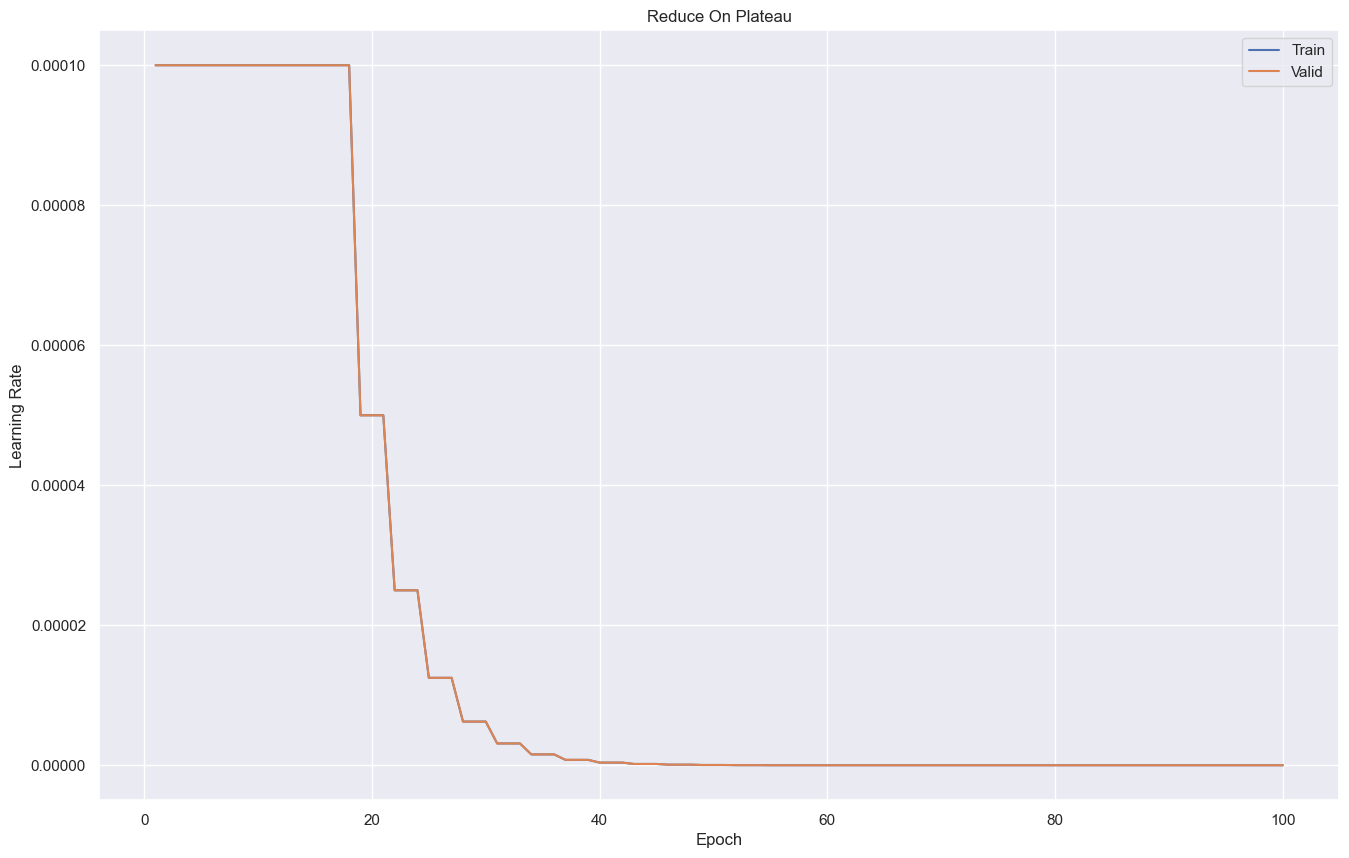

In [19]:
# Display the training and validation learning rate curves

cnn_plot.show_lr(
	report   = report,
	title    = 'Reduce On Plateau',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

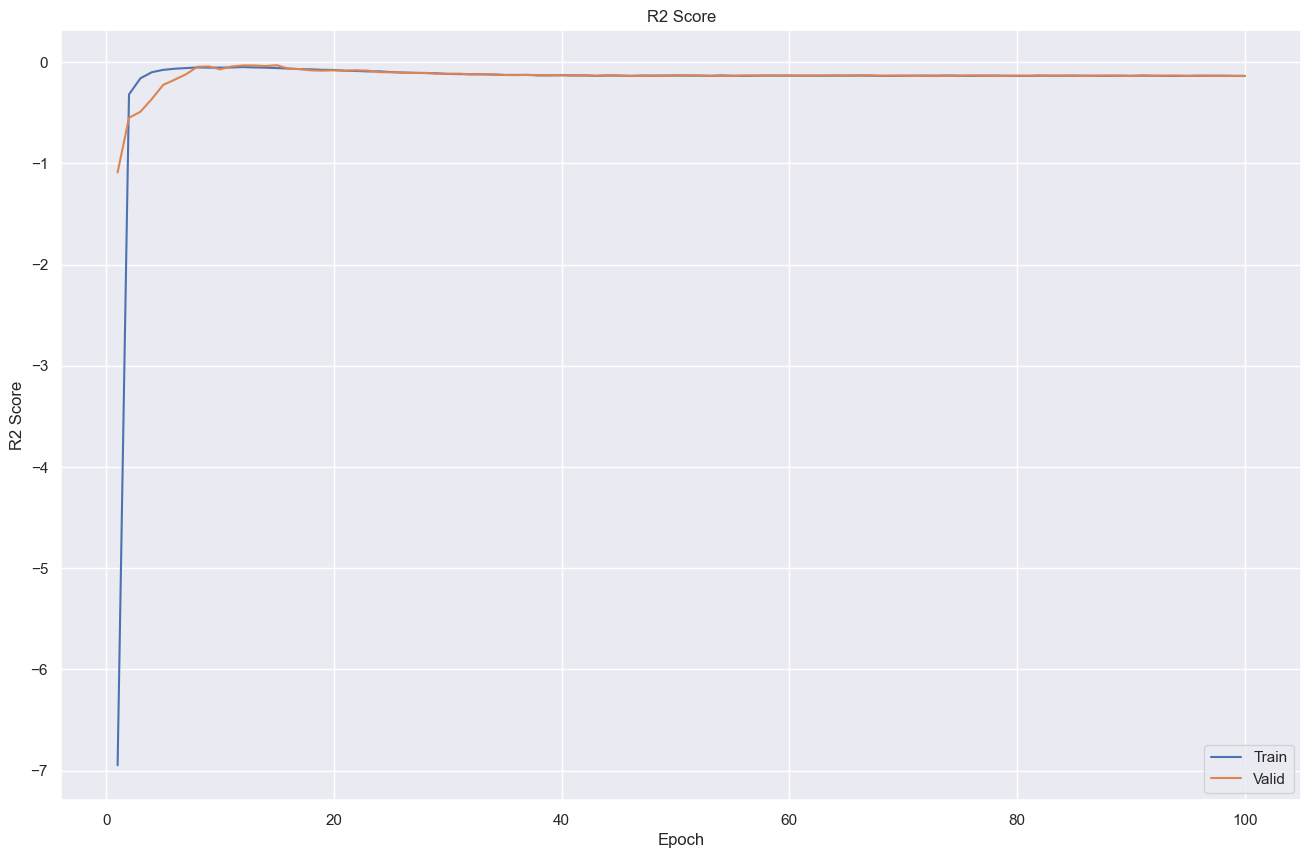

In [20]:
# Display the training and validation r2 score curves

cnn_plot.show_r2(
	report   = report,
	title    = 'R2 Score',
	filename = os.path.join(OUT_PLOT, model.__name__)
)

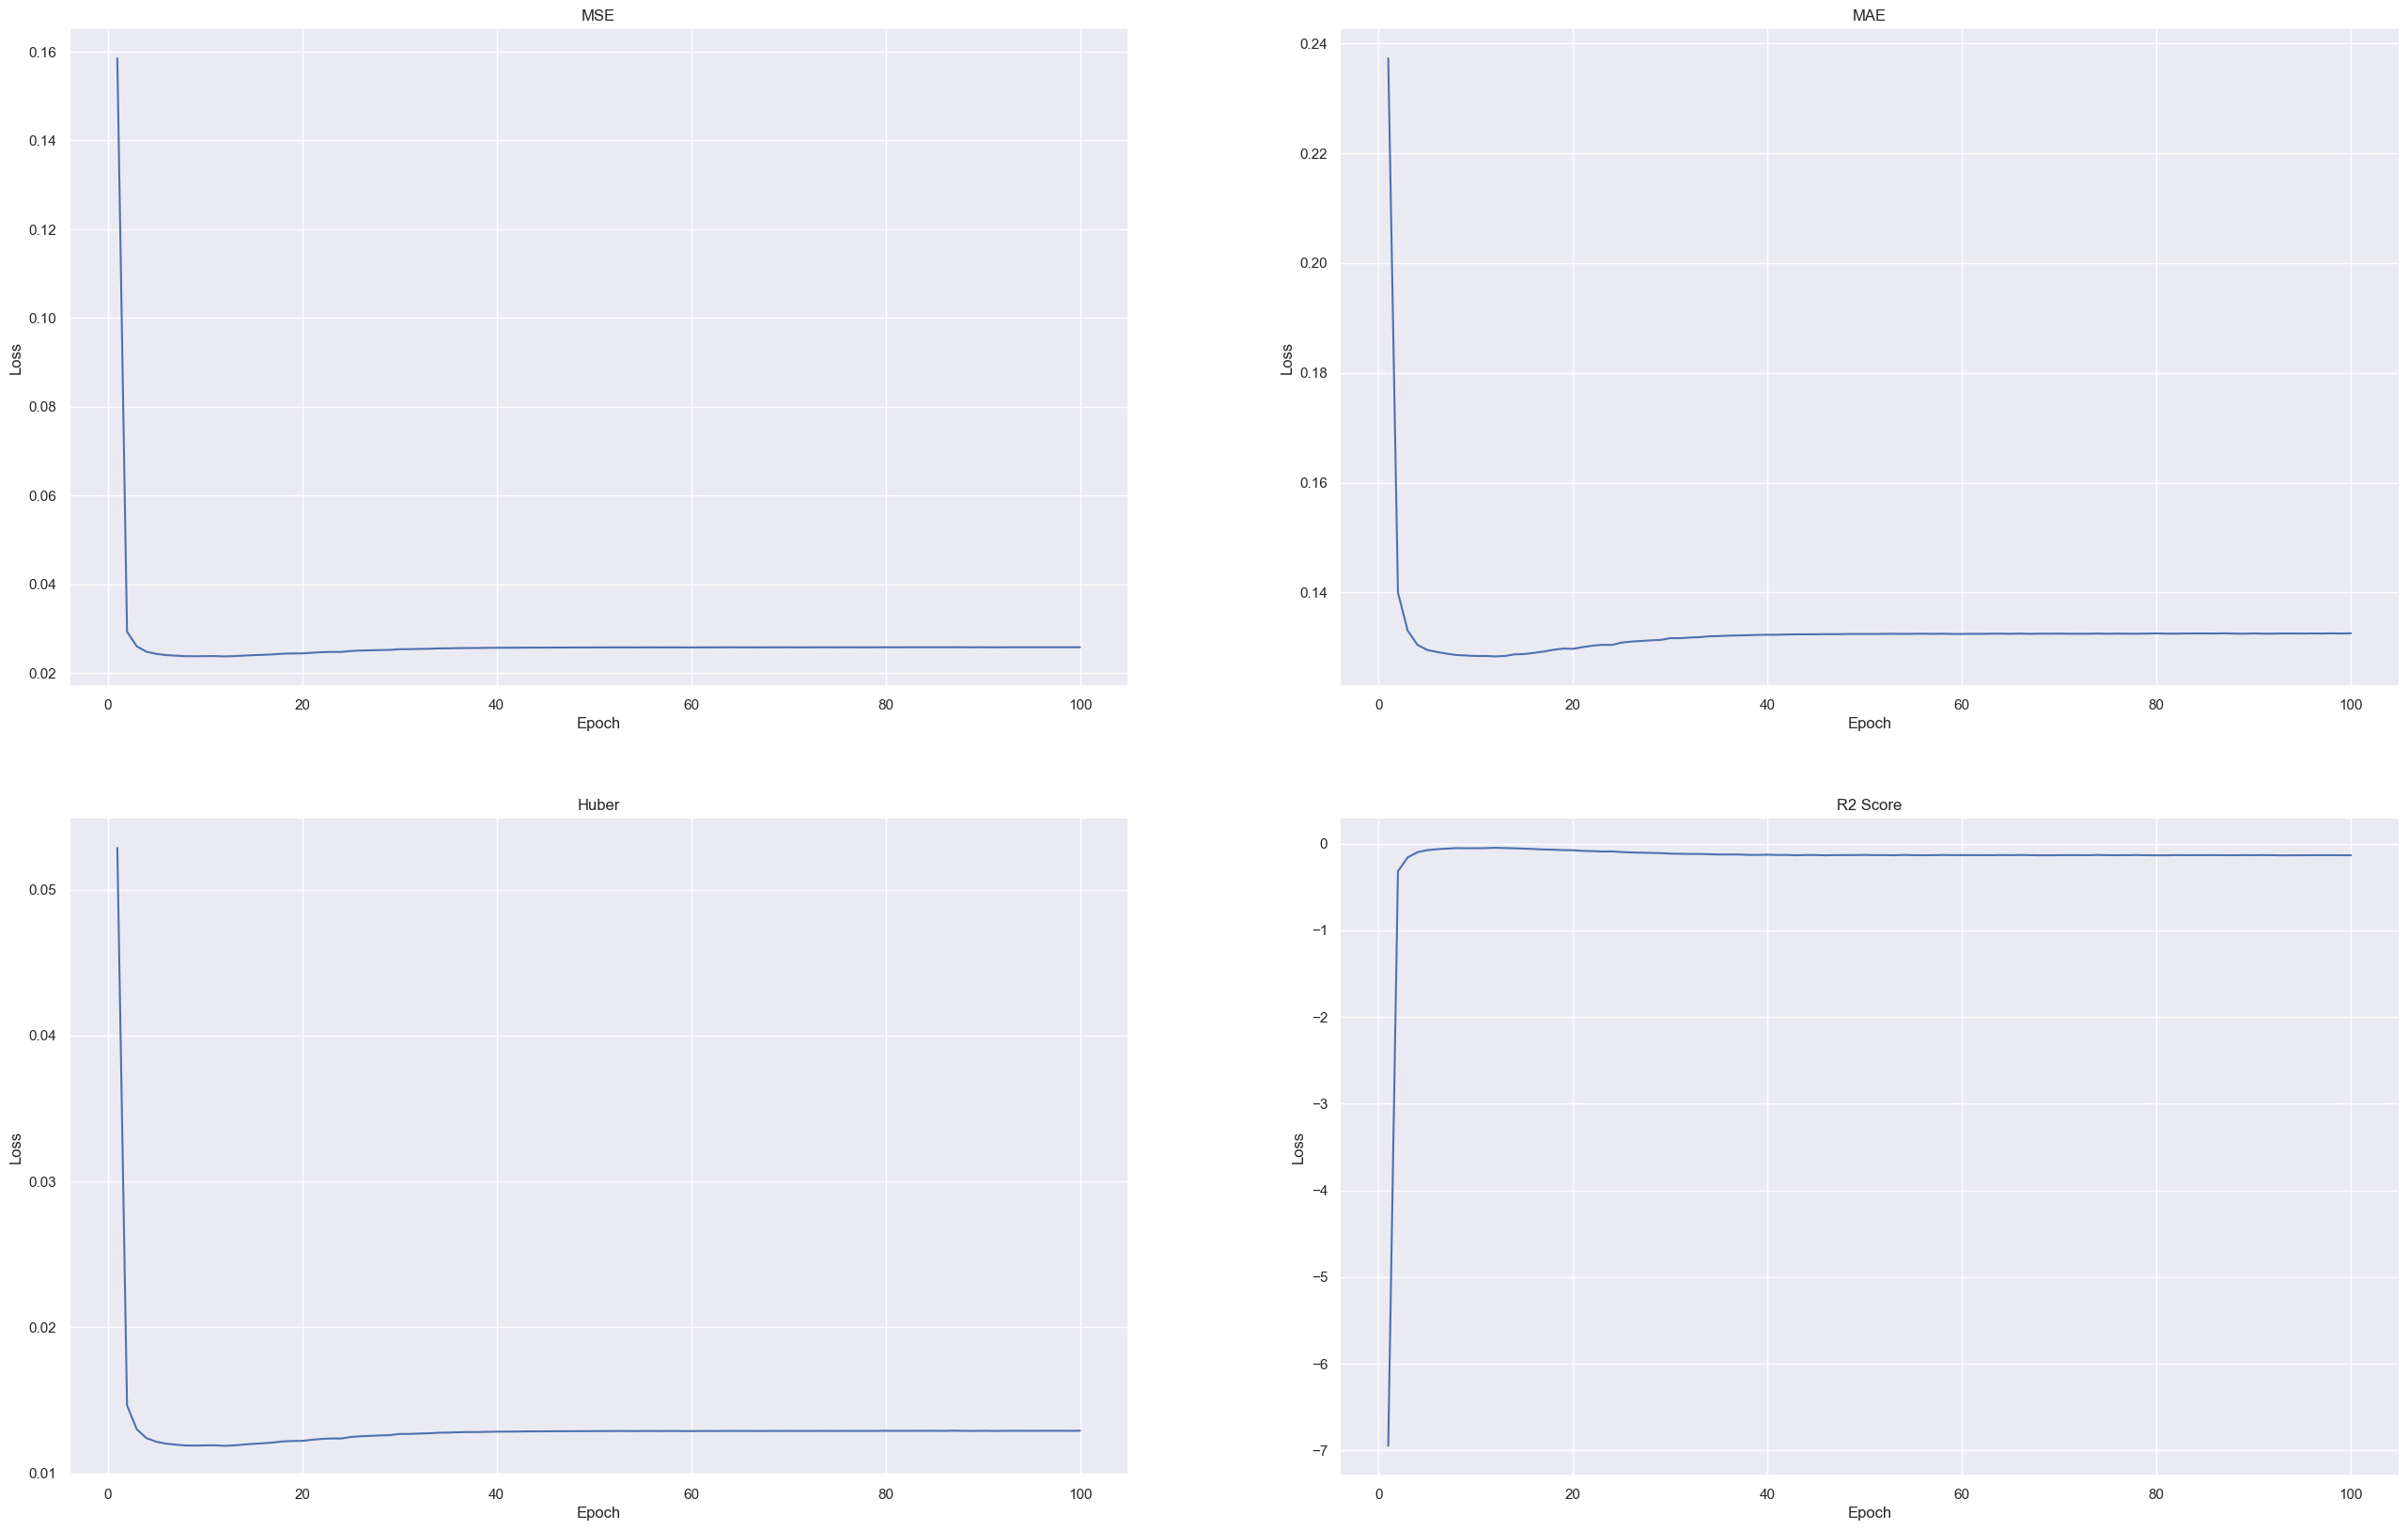

In [21]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'train',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-train')
)

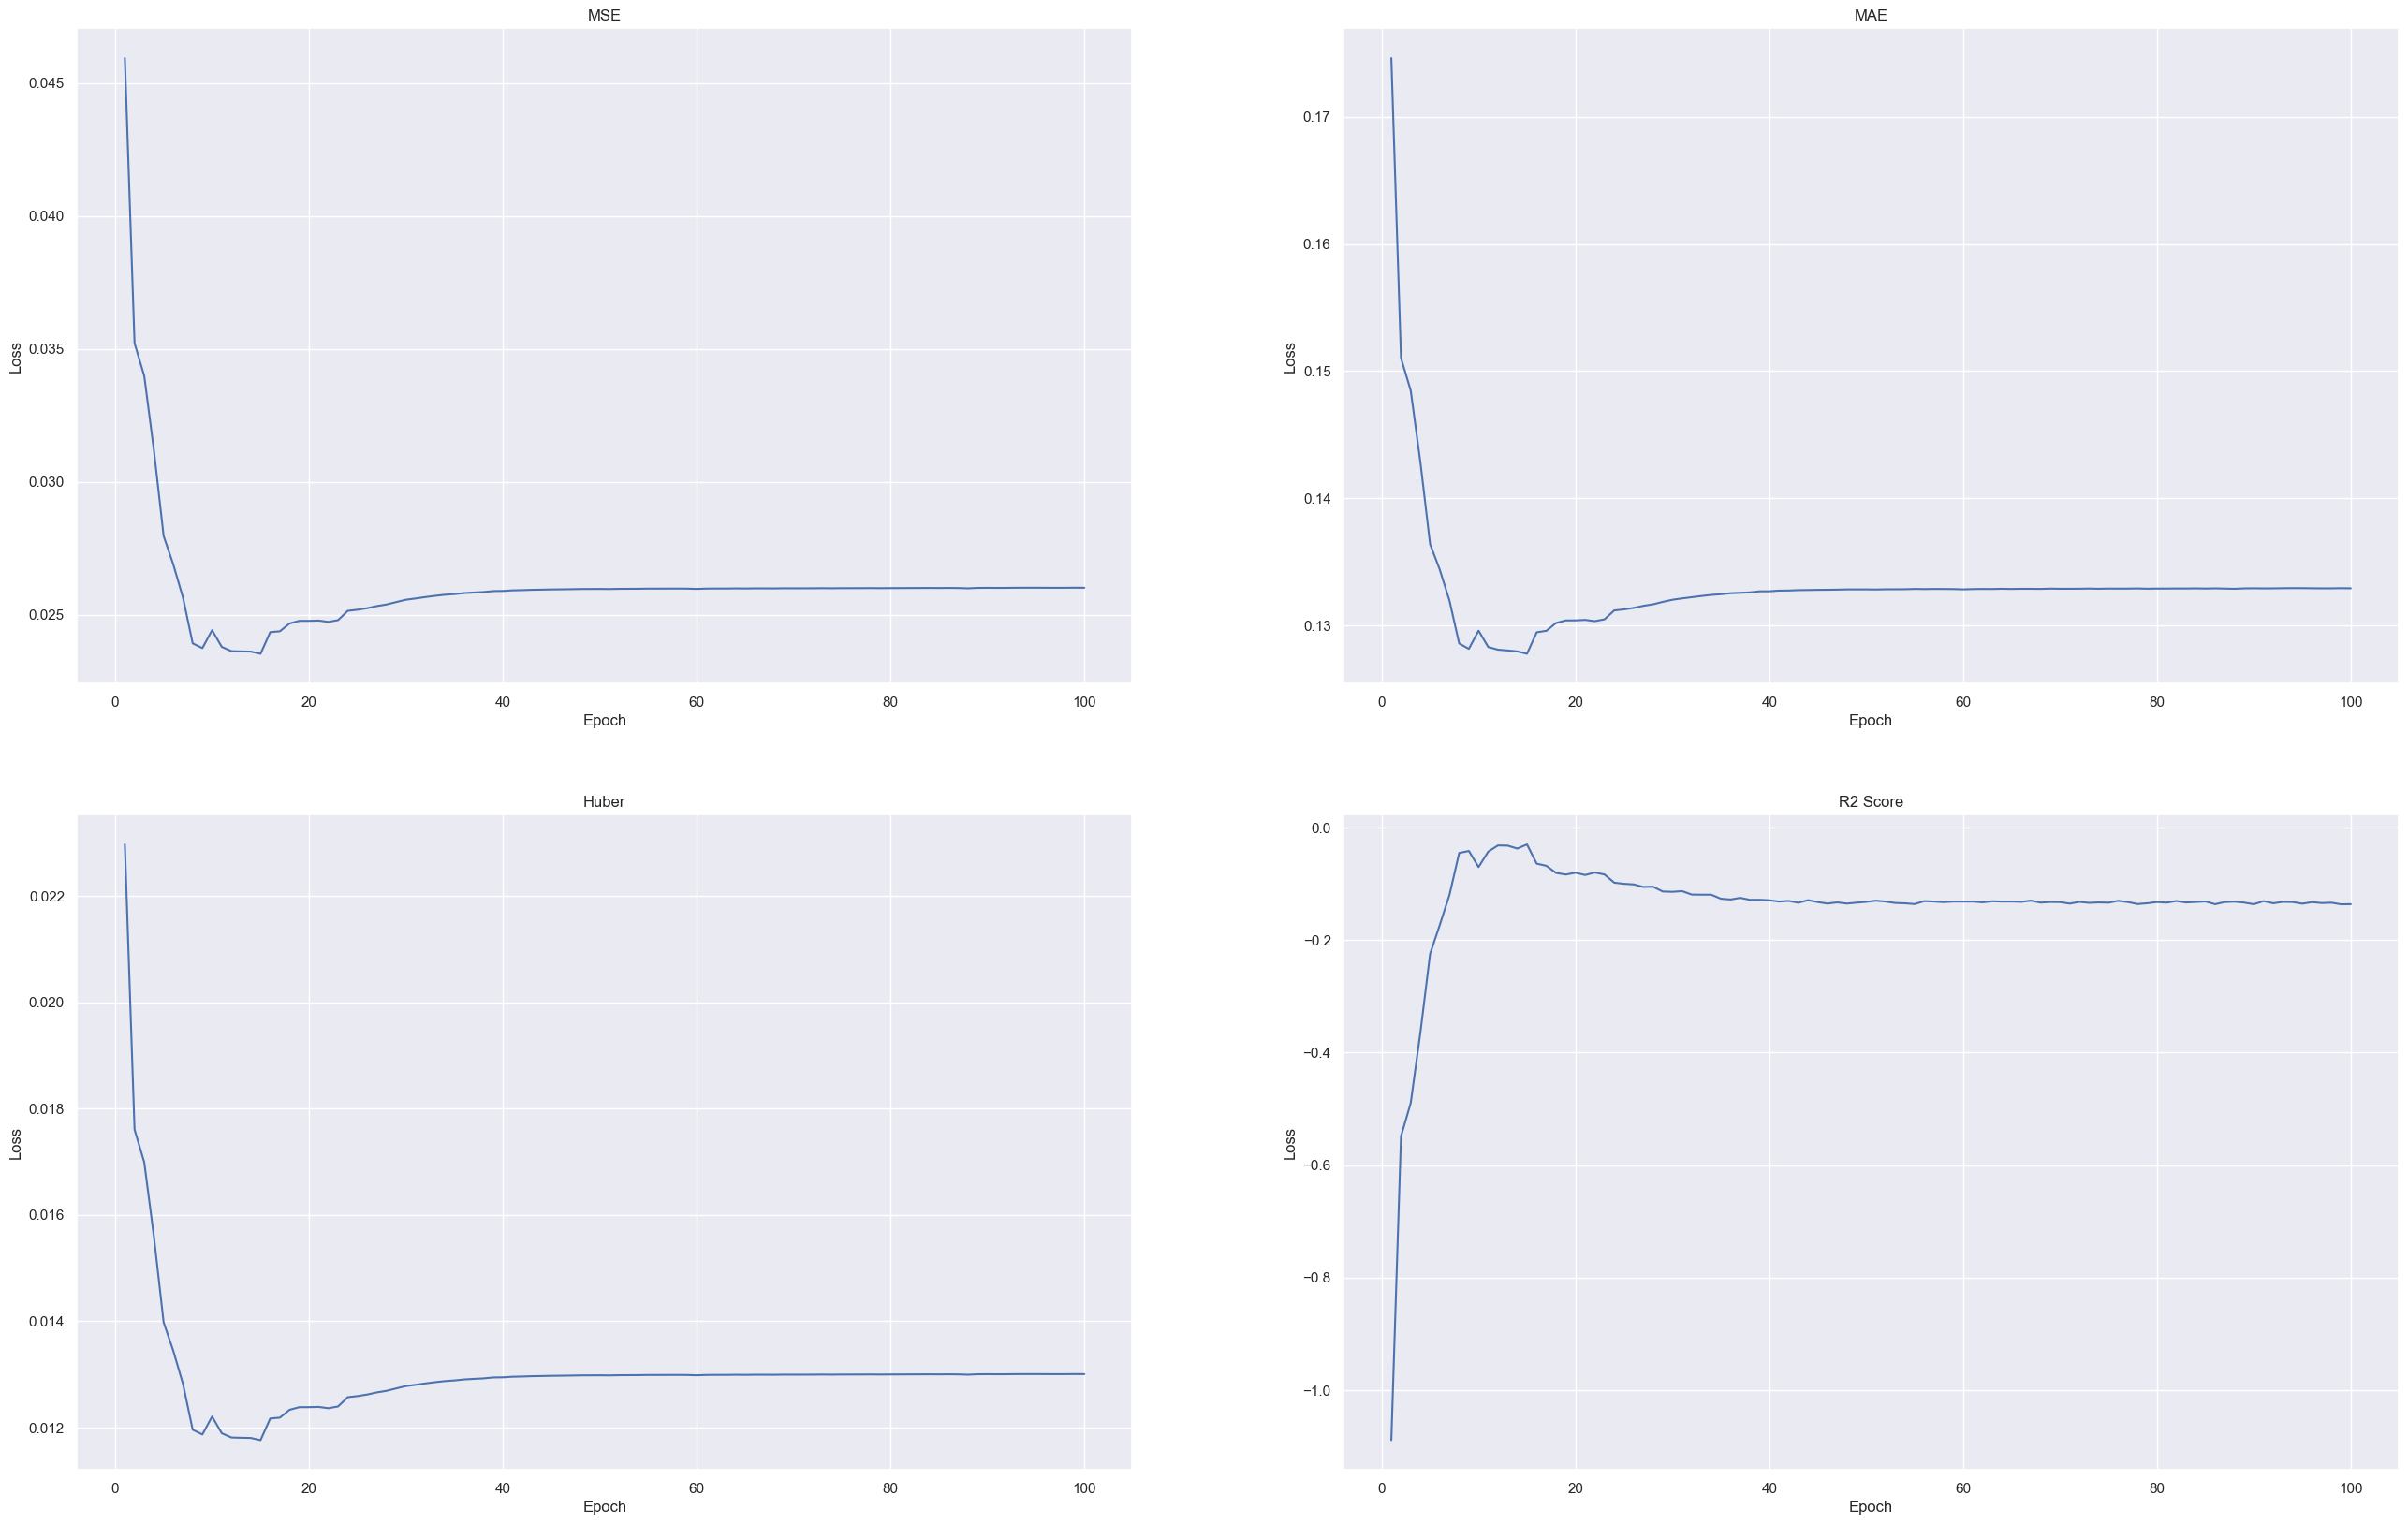

In [22]:
# Display the training metrics per batch

cnn_plot.show_metric_grid(
	report   = report,
	mode     = 'valid',
	filename = os.path.join(OUT_PLOT, model.__name__ + '-valid')
)

## 2.4 Evaluation

### 2.4.1 Last Model

In [23]:
# Load last model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-last.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 100
Loss  : 0.02601


<All keys matched successfully>

In [24]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [25]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.14255
MAE Loss :  0.13376
MSE Loss :  0.02622


In [26]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT5G57350.1
True : [0.34136   0.40474   0.26719   0.23943   0.30603   0.33270   0.30433   0.09279]
Pred : [0.25892   0.22343   0.22703   0.24759   0.23350   0.24854   0.18430   0.13636]
 MAE : [0.08244   0.18131   0.04016   0.00816   0.07253   0.08416   0.12002   0.04357]
 MSE : [0.00680   0.03287   0.00161   0.00007   0.00526   0.00708   0.01440   0.00190]

Gene : AT3G51270.4
True : [0.26183   0.15783   0.13679   0.26288   0.22202   0.20369   0.12748   0.01796]
Pred : [0.25892   0.22343   0.22703   0.24760   0.23351   0.24854   0.18431   0.13636]
 MAE : [0.00290   0.06561   0.09025   0.01528   0.01149   0.04486   0.05683   0.11840]
 MSE : [0.00001   0.00430   0.00814   0.00023   0.00013   0.00201   0.00323   0.01402]



In [27]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 44.65159 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
7,senescence_reproductive,6336,3985,62.89,0.09,0.07
6,senescence_green,6336,3928,61.99,0.13,0.08
2,other,6336,3279,51.75,0.13,0.08
4,seed,6336,2729,43.07,0.14,0.09
1,leaf,6336,2325,36.70,0.14,0.10
5,seedling,6336,2283,36.03,0.14,0.09
3,root,6336,2238,35.32,0.15,0.10
0,flower,6336,1866,29.45,0.15,0.10


### 2.4.2 Best Model

In [28]:
# Load best model

checkpoint = data_loader.load_torch(
	filename = os.path.join(OUT_MODEL, model.__name__ + '-best.pth')
)

print('Epoch : ' + '{}'.format(checkpoint['epoch']))
print('Loss  : ' + '{:.5f}'.format(checkpoint['loss']))

model.load_state_dict(checkpoint['models'])

Epoch : 15
Loss  : 0.02352


<All keys matched successfully>

In [29]:
# Evaluate the model

report = cnn_model.eval_regressor(
	model  = model,
	params = params
)

In [30]:
# Print the evaluation metrics

print('R2 Score : ' + '{: 8.5f}'.format(report['eval']['metric']['r2'].mean()))
print('MAE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mae'].mean()))
print('MSE Loss : ' + '{: 8.5f}'.format(report['eval']['metric']['mse'].mean()))

R2 Score : -0.03656
MAE Loss :  0.12803
MSE Loss :  0.02360


In [31]:
# Display the first few evaluation item predictions and expectations

cnn_util.display_regression_predictions(report = report, n = 2)

Gene : AT3G54860.2
True : [0.16628   0.08570   0.16007   0.11360   0.11015   0.13261   0.08961   0.24221]
Pred : [0.32574   0.23797   0.24060   0.30146   0.28066   0.26777   0.19749   0.14949]
 MAE : [0.15946   0.15226   0.08054   0.18786   0.17051   0.13517   0.10788   0.09271]
 MSE : [0.02543   0.02318   0.00649   0.03529   0.02907   0.01827   0.01164   0.00860]

Gene : AT3G57470.6
True : [0.33609   0.22573   0.23704   0.17971   0.23378   0.24796   0.15157   0.10895]
Pred : [0.34286   0.24383   0.24653   0.31782   0.29565   0.27460   0.20253   0.15437]
 MAE : [0.00677   0.01809   0.00948   0.13811   0.06187   0.02664   0.05097   0.04542]
 MSE : [0.00005   0.00033   0.00009   0.01907   0.00383   0.00071   0.00260   0.00206]



In [32]:
# Display the evaluation accuracy

dataframe = cnn_util.display_regression_accuracy(
	report    = report['eval'],
	order     = tpm_order[config['output']['group0']],
	threshold = {
		key : value[config['output']['group0'] + '-std']
		for key, value in tpm_value.items()
	}
).sort_values('Accuracy', ascending = False)

print('Accuracy : {:8.5f} %'.format(dataframe['Accuracy'].mean()))
print()

dataframe

Accuracy : 44.52139 %



,Group,Total,Count,Accuracy,Avg MAE,Std MAE
6,senescence_green,6336,3986,62.91,0.12,0.08
7,senescence_reproductive,6336,3893,61.44,0.10,0.07
2,other,6336,3371,53.20,0.12,0.08
4,seed,6336,2634,41.57,0.13,0.08
1,leaf,6336,2368,37.37,0.14,0.09
5,seedling,6336,2270,35.83,0.14,0.09
3,root,6336,2256,35.61,0.14,0.09
0,flower,6336,1789,28.24,0.13,0.09


## 2.5 Visualizaton